In [1]:
import os
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch
import os
import torchvision.models as models
import torch.nn as nn
from torchvision import transforms

c:\Users\jarne\miniconda3\envs\deepproblog\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
script_dir = os.getcwd()
emotion_processor = AutoImageProcessor.from_pretrained("trpakov/vit-face-expression")
multi_face_model = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")

scene_weights_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
scene_checkpoint = torch.hub.load_state_dict_from_url(scene_weights_url, map_location="cpu")

original_scene_model = models.resnet18(num_classes=365)
original_scene_model.fc = nn.Linear(original_scene_model.fc.in_features, 365)
scene_state_dict = {k.replace("module.", ""): v for k, v in scene_checkpoint["state_dict"].items()}
original_scene_model.load_state_dict(scene_state_dict)
original_scene_model.eval()

# Preprocessing, the standard torchvision normalization for ResNet, VGG, DenseNet...
scene_tf = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 1488.93it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 1488.93it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [3]:
from deepproblog.network import Network 
import torch.nn.functional as F

original_hf_emotion_model = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")

class MultiFaceWrapperFlat(nn.Module):
    def __init__(self, hf_model, max_faces=5):
        super().__init__()
        self.hf_model = hf_model
        self.max_faces = max_faces

    def forward(self, x):
        if isinstance(x, list) and len(x) == 1 and isinstance(x[0], list):
            face_tensors = x[0]
        elif isinstance(x, list):
            face_tensors = x
        else:
            face_tensors = [x]
        
        face_probs_list = []
        
        for i, face_tensor in enumerate(face_tensors[:self.max_faces]):
            if torch.is_tensor(face_tensor):
                face_batch = face_tensor.unsqueeze(0)
                outputs = self.hf_model(face_batch)
                probs = F.softmax(outputs.logits, dim=-1)
                face_probs_list.append(probs.squeeze(0)) 
        
        while len(face_probs_list) < self.max_faces:
            face_probs_list.append(torch.zeros(7))
        
        result = torch.cat(face_probs_list, dim=0)
        return result

max_faces = 5
multi_face_model = MultiFaceWrapperFlat(original_hf_emotion_model, max_faces=max_faces)

multi_face_network = Network(multi_face_model, "multi_face_net", batching=False)
multi_face_network.optimizer = torch.optim.Adam(multi_face_network.parameters(), lr=1e-3)
    
class SceneWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        if isinstance(x, list):
            x = torch.stack(x, dim=0)
        elif len(x.shape) == 3:
            x = x.unsqueeze(0)
            
        logits = self.model(x)
        probs = F.softmax(logits, dim=-1)
        return probs

scene_model = SceneWrapper(original_scene_model)
scene_network = Network(scene_model, "scene_net", batching=True)
scene_network.optimizer = torch.optim.Adam(scene_network.parameters(), lr=1e-3)

In [4]:
import os
import pandas as pd
import random
from io import StringIO
import matplotlib.pyplot as plt
from IPython.display import display
import random
import matplotlib.pyplot as plt
import cv2
from PIL import Image

script_dir = os.getcwd()
labels_dir = os.path.join(script_dir, "../data/findingemo/labels")
base_findingemo_dir = os.path.join(script_dir, "../data/findingemo")
csv_path = os.path.join(labels_dir, "annotations_cleaned.csv")
df_findingEmo = pd.read_csv(csv_path)

In [5]:
# Get the different emotions from FindingEmo
emotion_labels_findingemo = df_findingEmo['emotion'].unique().tolist()
emotion_to_idx = {emotion: idx for idx, emotion in enumerate(emotion_labels_findingemo)}
print(emotion_labels_findingemo)

['Trust', 'Interest', 'Apprehension', 'Anticipation', 'Anger', 'Joy', 'Grief', 'Serenity', 'Boredom', 'Ecstasy', 'Fear', 'Vigilance', 'Sadness', 'Rage', 'Annoyance', 'Acceptance', 'Terror', 'Amazement', 'Surprise', 'Pensiveness', 'Admiration', 'Loathing', 'Distraction', 'Disgust']


In [6]:
# train_test split
from sklearn.model_selection import train_test_split
# Shuffle the dataset
df_findingEmo = df_findingEmo.sample(frac=1, random_state=42).reset_index(drop=True)
train_df, test_df = train_test_split(df_findingEmo, test_size=0.2, random_state=42)

# reset indexes
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df = train_df.iloc[:200]

In [7]:
from mtcnn import MTCNN
# Image access (tensors) - separate classes for different preprocessing
class FindingEmoFaceImages(object):
    def __init__(self, subset, print_cropped=False):
        self.subset = subset
        self.face_detector = MTCNN()
        self.print_cropped = print_cropped

        if self.subset == "train":
            self.dataframe = train_df.copy()
        else:
            self.dataframe = test_df.copy()
# Will return a list of tensors corresponding to all the detected faces.
# If no face is detected, just return the tensor of the image.
    def __getitem__(self, item):
        index = int(item[0]) if isinstance(item, (tuple, list)) else int(item)
        
        image_path = self.dataframe["image_path"][index]
        if image_path.startswith('/'):
            image_path = image_path[1:]
        
        img_path = os.path.join(base_findingemo_dir, image_path)
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Detect the faces
        face_results = self.face_detector.detect_faces(img)

        # Sort faces by x-coordinate (left to right)
        if len(face_results) > 0:
            face_results.sort(key=lambda face: face['box'][0])

        # Only max faces
        face_results = face_results[:max_faces]

        face_tensors = []
        face_pils = []

        if len(face_results) > 0:
            for face_result in face_results:
                x, y, w, h = face_result['box']

                # Handle negative coordinates and bounds
                x = max(0, x)
                y = max(0, y)
                x2 = min(img.shape[1], x + w)
                y2 = min(img.shape[0], y + h)

                # Face crop
                face_crop = img[y:y2, x:x2] 
                # Skip if the crop is too small
                if face_crop.shape[0] < 10 or face_crop.shape[1] < 10:
                    continue

                # Converting to PIL and process it with HF processor
                face_pil = Image.fromarray(face_crop)
                face_pils.append(face_pil)
                face_input = emotion_processor(images=face_pil, return_tensors="pt")
                face_tensors.append(face_input['pixel_values'].squeeze(0))

        if len(face_tensors) == 0:
            # Use whole image as fallback
            img_pil = Image.fromarray(img)
            face_input = emotion_processor(images = img_pil, return_tensors="pt")
            face_tensors.append(face_input['pixel_values'].squeeze(0))

        if self.print_cropped:
            # Display cropped faces
            num_faces = len(face_pils)
            if num_faces > 0:
                plt.figure(figsize=(8, 3))
            for i, face_pil in enumerate(face_pils):
                plt.subplot(1, num_faces, i + 1)
                plt.imshow(face_pil)
                plt.title(f'Face {i}')
                plt.axis('off')
            plt.show()
            
            self.print_cropped = False
            
        return face_tensors

class FindingEmoSceneImages(object):
    def __init__(self, subset):
        self.subset = subset
        if self.subset == "train":
            self.dataframe = train_df.copy()
        else:
            self.dataframe = test_df.copy()
            
    def __getitem__(self, item):
        index = int(item[0]) if isinstance(item, (tuple, list)) else int(item)
        
        image_path = self.dataframe["image_path"][index]
        if image_path.startswith('/'):
            image_path = image_path[1:]
        
        img_path = os.path.join(base_findingemo_dir, image_path)
        
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image not found: {img_path}")
            
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Failed to load image: {img_path}")
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img)
        
        # Use scene transforms for scene model
        scene_tensor = scene_tf(img_pil)
        return scene_tensor

# Create separate instances
FindingEmoFace_train = FindingEmoFaceImages("train", print_cropped=True)
FindingEmoFace_test = FindingEmoFaceImages("test")
FindingEmoScene_train = FindingEmoSceneImages("train") 
FindingEmoScene_test = FindingEmoSceneImages("test")

In [8]:
emotion_categories = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

In [9]:
# Mapping for the scene categories. Read them from ../data/places365/categories_places365.txt
scene_categories = []
with open(os.path.join(script_dir, "../data/places365/categories_places365.txt")) as f:
    for line in f:
        scene = line.strip().split(' ')[0][3:]
        scene_categories.append(scene)

model_scene_to_index = {scene: idx for idx, scene in enumerate(scene_categories)}

In [10]:
from deepproblog.model import Model
from deepproblog.network import Network
from deepproblog.engines import ExactEngine
from deepproblog.dataset import Dataset, DataLoader
from torch.utils.data import Dataset as TorchDataset
from problog.logic import Term, Constant, Var
from deepproblog.query import Query
from deepproblog.train import train_model

In [11]:
num_emotions = len(emotion_categories) * max_faces
num_scenes = len(scene_categories)

emotion_indices = list(range(num_emotions))
scene_indices = list(range(num_scenes))

In [12]:
train_indices = list(range(len(train_df))) 
test_indices = list(range(len(test_df))) 

In [13]:
from deepproblog.engines import ApproximateEngine, ExactEngine
# Create model
model = Model(
    os.path.join(script_dir, "model.pl"),
    [multi_face_network, scene_network]
)
model.set_engine(ExactEngine(model), cache=True)
# model.set_engine(
#             ApproximateEngine(model, 1, ApproximateEngine.geometric_mean, exploration=False)
#         )

# Register tensor sources
model.add_tensor_source("train_face", FindingEmoFace_train)
model.add_tensor_source("test_face", FindingEmoFace_test)
model.add_tensor_source("train_scene", FindingEmoScene_train)
model.add_tensor_source("test_scene", FindingEmoScene_test)

Caching ACs


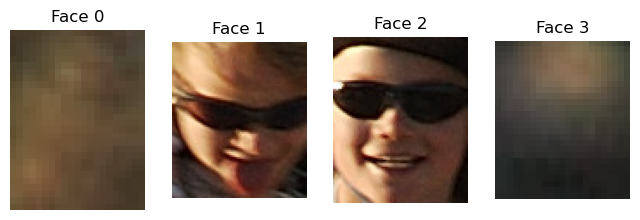

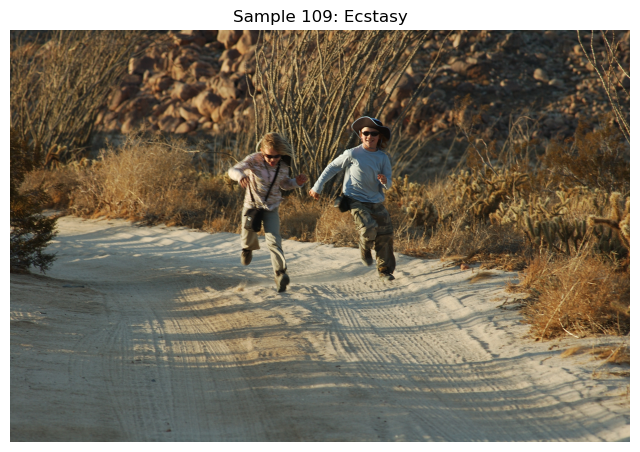

Number of detected faces: 4


c:\Users\jarne\miniconda3\envs\deepproblog\lib\site-packages\deepproblog\semiring\graph_semiring.py:77: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  return -self.eps <= float(a) <= self.eps


Enhanced Final Emotion Predictions (sorted by probability):
Ecstasy        : 0.0913
Acceptance     : 0.0837
Joy            : 0.0754
Admiration     : 0.0700
Serenity       : 0.0460
Sadness        : 0.0107
Pensiveness    : 0.0106
Grief          : 0.0048
Annoyance      : 0.0041
Rage           : 0.0031
Amazement      : 0.0028
Fear           : 0.0027
Surprise       : 0.0026
Boredom        : 0.0021
Terror         : 0.0011
Apprehension   : 0.0010
Disgust        : 0.0009
Vigilance      : 0.0008
Loathing       : 0.0008
Anger          : 0.0004
Distraction    : 0.0003

Ground Truth: ECSTASY


In [14]:
train_sample_idx = random.randint(0, len(train_df) - 1)
# train_sample_idx = 16768

# print("Random index: ", train_sample_idx )
face_tensors = FindingEmoFace_train[(train_sample_idx,)]

# display original image
img_path = os.path.join(base_findingemo_dir, train_df.iloc[train_sample_idx]['image_path'])
img = cv2.imread(img_path)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 6))
plt.imshow(img_rgb)
plt.axis('off')
plt.title(f"Sample {train_sample_idx}: {train_df.iloc[train_sample_idx]['emotion']}")
plt.show()

print(f"Number of detected faces: {len(face_tensors)}")

query = Query(
    Term("final_emotion",
         Term("tensor", Term("train_face", Constant(train_sample_idx))),
         Term("tensor", Term("train_scene", Constant(train_sample_idx))),
         Var("FindingEmoIdx")),
    substitution={}
)

results_final = model.solve([query])
results_final_dict = results_final[0].result

# Sort by tensor values and display in a readable format
sorted_results = sorted(results_final_dict.items(), key=lambda x: x[1].item(), reverse=True)

print("Enhanced Final Emotion Predictions (sorted by probability):")
print("=" * 60)

for key, tensor_val in sorted_results:
    # Extract emotion index from the key
    key_str = str(key)
    emotion_idx = int(key_str.split(",")[-1][:-1])
    emotion_name = emotion_labels_findingemo[emotion_idx]
    probability = tensor_val.item()
    
    print(f"{emotion_name:15}: {probability:.4f}")

print(f"\nGround Truth: {train_df.iloc[train_sample_idx]['emotion'].upper()}")

In [15]:
# Query emotion distribution over the detected faces
query_1 = Query(
    Term("faces",
         Term("tensor", Term("train_face", Constant(train_sample_idx))),
         Var("AllEmotions")),
    substitution={}
)

results_1 = model.solve([query_1])
results_1_dict = results_1[0].result

emotion_probs = []
for i in range(max_faces * len(emotion_categories)): 
    key_found = False
    for key, prob in results_1_dict.items():
        # Extract index from the key string like "faces(tensor(train_face(1234)),5)"
        if str(key).endswith(f",{i})"):
            emotion_probs.append(prob)
            key_found = True
            break
    if not key_found:
        emotion_probs.append(0.0) 

for face_idx in range(max_faces):
    start_idx = face_idx * 7
    end_idx = start_idx + 7
    face_emotion_probs = emotion_probs[start_idx:end_idx]
    
    if sum(face_emotion_probs) > 0.01:  
        print(f"FACE {face_idx}:")
        print("")
        
        emotion_prob_pairs = [(emotion_categories[i], prob) for i, prob in enumerate(face_emotion_probs)]
        
        for emotion, prob in emotion_prob_pairs:
            print(f"{emotion:8}: {prob:.4f}")

print(f"Ground Truth Emotion: {train_df.iloc[train_sample_idx]['emotion'].upper()}")

FACE 0:

angry   : 0.3265
disgust : 0.0228
fear    : 0.1219
happy   : 0.1340
sad     : 0.1123
surprise: 0.1882
neutral : 0.0943
FACE 1:

angry   : 0.0016
disgust : 0.0004
fear    : 0.0006
happy   : 0.9935
sad     : 0.0011
surprise: 0.0007
neutral : 0.0021
FACE 2:

angry   : 0.0003
disgust : 0.0007
fear    : 0.0003
happy   : 0.9925
sad     : 0.0029
surprise: 0.0004
neutral : 0.0030
FACE 3:

angry   : 0.1966
disgust : 0.0615
fear    : 0.1220
happy   : 0.1398
sad     : 0.1422
surprise: 0.2048
neutral : 0.1331
Ground Truth Emotion: ECSTASY


In [16]:
# Probability of face 1 being happy:
query_2 = Query(
    Term("face_emotion_prob",
         Term("tensor", Term("train_face", Constant(train_sample_idx))),
         Constant(1),
         Constant(emotion_categories.index('happy'))),
    substitution={}
)

results_2 = model.solve([query_2])
print(results_2)

[{face_emotion_prob(tensor(train_face(109)),1,3): tensor(0.9935, grad_fn=<SelectBackward0>)}]


In [17]:
# Probability distribution over all emotions for face 1:
query_3 = Query(
    Term("face_emotion_prob",
         Term("tensor", Term("train_face", Constant(train_sample_idx))),
         Constant(1),
         Var("EmotionIdx")),
    substitution={}
)

results_3 = model.solve([query_3])
print(results_3)

[{face_emotion_prob(tensor(train_face(109)),1,0): tensor(0.0016, grad_fn=<SelectBackward0>), face_emotion_prob(tensor(train_face(109)),1,1): tensor(0.0004, grad_fn=<SelectBackward0>), face_emotion_prob(tensor(train_face(109)),1,2): tensor(0.0006, grad_fn=<SelectBackward0>), face_emotion_prob(tensor(train_face(109)),1,3): tensor(0.9935, grad_fn=<SelectBackward0>), face_emotion_prob(tensor(train_face(109)),1,4): tensor(0.0011, grad_fn=<SelectBackward0>), face_emotion_prob(tensor(train_face(109)),1,5): tensor(0.0007, grad_fn=<SelectBackward0>), face_emotion_prob(tensor(train_face(109)),1,6): tensor(0.0021, grad_fn=<SelectBackward0>)}]


In [ ]:
# Scene distribution
query_4 = Query(
    Term("scene",
         Term("tensor", Term("train_scene", Constant(train_sample_idx))),
         Var("SceneIdx")),
    substitution={}
)

results_4 = model.solve([query_4])

results_4_dict = results_4[0].result

top_scenes = {}
for key, prob in results_4_dict.items():
    # Extract index from the key string like "scene(tensor(train_scene(1234)),5)"
    if str(key).endswith(")"):
        scene_idx = int(str(key).split(",")[-1][:-1])
        scene_name = scene_categories[scene_idx]
        top_scenes[scene_name] = prob

top_scenes_sorted = dict(sorted(top_scenes.items(), key=lambda item: item[1], reverse=True))
print("\nTop scene predictions:")
for scene, prob in list(top_scenes_sorted.items())[:10]:
    print(f"   {scene:20}: {prob:.4f}")

In [19]:
import json
from typing import Tuple

# Dataset for training
class FindingEmoDataset(Dataset, TorchDataset):
    def __init__(self, dataframe, subset_name, function_name="final_emotion"):
        super(FindingEmoDataset, self).__init__()
        self.dataframe = dataframe.reset_index(drop=True)
        self.subset_name = subset_name
        self.function_name = function_name
        self.data = list(range(len(self.dataframe)))
    
    def __getitem__(self, index: int) -> Tuple[int, str, int]:
        sample_idx = self.data[index]
        emotion_name = self.dataframe.iloc[sample_idx]['emotion']
        emotion_idx = emotion_to_idx[emotion_name]
        return sample_idx, emotion_name, emotion_idx
    
    def __len__(self):
        return len(self.data)
    
    def to_query(self, i: int) -> Query:
        sample_idx = self.data[i]
        emotion_idx = emotion_to_idx[self.dataframe.iloc[sample_idx]['emotion']]
        
        query = Query(
            Term(self.function_name,
                 Term("tensor", Term(f"{self.subset_name}_face", Constant(sample_idx))),
                 Term("tensor", Term(f"{self.subset_name}_scene", Constant(sample_idx))),
                 Constant(emotion_idx)),  # Ground truth
            substitution={}
        )
        return query
    
    def get_label(self, i: int):
        sample_idx = self.data[i]
        emotion_name = self.dataframe.iloc[sample_idx]['emotion']
        return emotion_to_idx[emotion_name]
    
    def get_emotion_name(self, i: int):
        sample_idx = self.data[i]
        return self.dataframe.iloc[sample_idx]['emotion']

train_dataset = FindingEmoDataset(train_df, "train")
test_dataset = FindingEmoDataset(test_df, "test")

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Test the dataset
sample_idx, emotion_name, emotion_idx = train_dataset[0]
print(f"Sample 0: idx={sample_idx}, emotion='{emotion_name}', label={emotion_idx}")

# Test query generation
query = train_dataset.to_query(0)
print(f"Generated query: {query}")

Train dataset size: 200
Test dataset size: 4275
Sample 0: idx=0, emotion='Vigilance', label=11
Generated query: (1.0::final_emotion(tensor(train_face(0)),tensor(train_scene(0)),11), {})


In [20]:
# # Ensure output folders exist
# snapshot_dir = os.path.join(script_dir, "snapshot")
# log_dir = os.path.join(script_dir, "log")
# os.makedirs(snapshot_dir, exist_ok=True)
# os.makedirs(log_dir, exist_ok=True)

In [21]:
# import torch.optim as optim
# from deepproblog.train import train_model
# from deepproblog.utils.stop_condition import EpochStop

# loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [22]:
# train = train_model(model, loader, EpochStop(1), log_iter=25, profile=0)

In [23]:
# from json import dumps
# from deepproblog.evaluate import get_confusion_matrix

# # Save results
# snapshot_path = os.path.join(snapshot_dir, "social_cognition" + ".pth")
# model.save_state(snapshot_path)
# print("Model snapshot saved to:", snapshot_path)

# log_path = os.path.join(log_dir, "social_cognition")
# train.logger.comment(dumps(model.get_hyperparameters()))
# train.logger.comment("Accuracy {}".format(get_confusion_matrix(model, test_dataset, verbose=1).accuracy()))
# train.logger.write_to_file(log_path)
# print("Training log written to:", log_path) 

In [24]:
snapshot_path = os.path.join(script_dir, "snapshot", "social_cognition.pth")

if os.path.exists(snapshot_path):
    print(f"Loading model from: {snapshot_path}")
    model.load_state(snapshot_path)
else:
    print("Error loading model")

Loading model from: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\snapshot\social_cognition.pth


Random index:  48


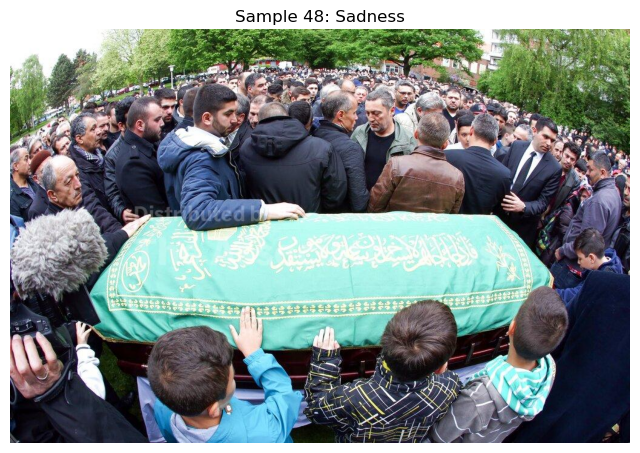

Number of detected faces: 5
Enhanced Final Emotion Predictions (sorted by probability):
Joy            : 1.5109
Acceptance     : 1.4903
Serenity       : 1.4702
Admiration     : 1.2309
Vigilance      : 0.2306
Boredom        : 0.2192
Sadness        : 0.1974
Terror         : 0.1685
Rage           : 0.1134
Ecstasy        : 0.0973
Annoyance      : 0.0753
Pensiveness    : 0.0753
Grief          : 0.0578
Fear           : 0.0508
Disgust        : 0.0444
Amazement      : 0.0349
Apprehension   : 0.0284
Distraction    : 0.0261
Loathing       : 0.0198
Surprise       : 0.0141
Anger          : 0.0088

Ground Truth: SADNESS
Enhanced Final Emotion Predictions (sorted by probability):
Joy            : 1.5109
Acceptance     : 1.4903
Serenity       : 1.4702
Admiration     : 1.2309
Vigilance      : 0.2306
Boredom        : 0.2192
Sadness        : 0.1974
Terror         : 0.1685
Rage           : 0.1134
Ecstasy        : 0.0973
Annoyance      : 0.0753
Pensiveness    : 0.0753
Grief          : 0.0578
Fear         

In [31]:
train_sample_idx = random.randint(0, len(train_df) - 1)

print("Random index: ", train_sample_idx )
face_tensors = FindingEmoFace_train[(train_sample_idx,)]

# display original image
img_path = os.path.join(base_findingemo_dir, train_df.iloc[train_sample_idx]['image_path'])
img = cv2.imread(img_path)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 6))
plt.imshow(img_rgb)
plt.axis('off')
plt.title(f"Sample {train_sample_idx}: {train_df.iloc[train_sample_idx]['emotion']}")
plt.show()

print(f"Number of detected faces: {len(face_tensors)}")

query = Query(
    Term("final_emotion",
         Term("tensor", Term("train_face", Constant(train_sample_idx))),
         Term("tensor", Term("train_scene", Constant(train_sample_idx))),
         Var("FindingEmoIdx")),
    substitution={}
)

results_final = model.solve([query])
results_final_dict = results_final[0].result

# Sort by tensor values and display in a readable format
sorted_results = sorted(results_final_dict.items(), key=lambda x: x[1].item(), reverse=True)

print("Enhanced Final Emotion Predictions (sorted by probability):")
print("=" * 60)

for key, tensor_val in sorted_results:
    # Extract emotion index from the key
    key_str = str(key)
    emotion_idx = int(key_str.split(",")[-1][:-1])
    emotion_name = emotion_labels_findingemo[emotion_idx]
    probability = tensor_val.item()
    
    print(f"{emotion_name:15}: {probability:.4f}")

print(f"\nGround Truth: {train_df.iloc[train_sample_idx]['emotion'].upper()}")